### 1.导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
%matplotlib inline

In [2]:
#step1.读取上市公司和子公司数据，并进行连接
df_com = pd.read_excel(r'../../file/subject/chapter3/SSGScompany04.xlsx')
df_son = pd.read_excel(r'../../file/subject/chapter3/company_info_all05.xlsx')
df = pd.merge(df_son,df_com,left_on='上市公司名称',right_on='公司名称2').reset_index()
#step2.筛选正常营业公司
df['公司状态'] = df['公司状态'].apply(lambda x:'开业' if x == 0 else x)
df = df[-df['公司状态'].str.startswith('吊销')]
#step3.筛选非同城公司以建立关联
city_net = df[['city_x','city_y']].rename(columns={'city_x':'ZGS_city','city_y':'SSGS_city'})
city_net['count'] = 1
city_net = city_net[-(city_net['ZGS_city'] == city_net['SSGS_city'])]
#step4.处理错误城市数据
city_net = city_net[-(city_net.ZGS_city.isin([0,'','']) | city_net.ZGS_city.isna())]
city_net.ZGS_city = city_net.ZGS_city.apply(lambda x:np.nan if x.isascii() else x)
city_net.dropna(inplace=True)

### 2.出入度分析

#### 2.1出度分析
出度：上市公司对外投资程度

In [3]:
city_net2 = city_net.copy()
city_net2.head()

,ZGS_city,SSGS_city,count
0,上海市,兰州市,1
9,张掖市,兰州市,1
15,酒泉市,兰州市,1
17,武威市,兰州市,1
21,张掖市,兰州市,1


In [4]:
city_net2.groupby(by='SSGS_city')['SSGS_city'].count().sort_values(ascending=False).head()

SSGS_city
北京市    6760
深圳市    2763
上海市    2114
杭州市    1025
广州市     937
Name: SSGS_city, dtype: int64

In [5]:
sum(city_net2.groupby(by='SSGS_city')['SSGS_city'].count().sort_values(ascending=False))

33776

#### 2.2入度分析
入度：接受上市公司投资的程度,总出度=总入度

In [6]:
city_net2.groupby(by='ZGS_city')['ZGS_city'].count().sort_values(ascending=False).head()

ZGS_city
上海市    2569
深圳市    2458
北京市    2244
杭州市     846
天津市     795
Name: ZGS_city, dtype: int64

In [7]:
sum(city_net2.groupby(by='ZGS_city')['ZGS_city'].count().sort_values(ascending=False))

33776

#### 2.3合并为DadaFrame对象

In [8]:
city_out = city_net2.groupby(by='SSGS_city')['SSGS_city'].count().sort_values(ascending=False)
city_in = city_net2.groupby(by='ZGS_city')['ZGS_city'].count().sort_values(ascending=False)

In [9]:
#Series转DataFrame
city_in = city_in.to_frame(name='in').reset_index()
city_out = city_out.to_frame(name='out').reset_index()

In [10]:
in_out = pd.merge(city_in,city_out,left_on='ZGS_city',right_on='SSGS_city')
in_out.head()

,ZGS_city,in,SSGS_city,out
0,上海市,2569,上海市,2114
1,深圳市,2458,深圳市,2763
2,北京市,2244,北京市,6760
3,杭州市,846,杭州市,1025
4,天津市,795,天津市,361


In [11]:
in_out = in_out[['ZGS_city','in','out']]
in_out['all'] = in_out['in'] + in_out['out']
in_out.head()

,ZGS_city,in,out,all
0,上海市,2569,2114,4683
1,深圳市,2458,2763,5221
2,北京市,2244,6760,9004
3,杭州市,846,1025,1871
4,天津市,795,361,1156


In [31]:
in_out.to_excel(r'../../file/subject/chapter3/in_out.xlsx',sheet_name='Sheet1')

### 3.四类城市组织中的节点连接排序

#### 3.1TOP1网络

In [13]:
city_net3 = city_net2.copy()

In [154]:
#统计上市公司和子公司分别同城个数,多重索引
city_net4 = city_net3.groupby(by=['SSGS_city','ZGS_city']).sum()
city_net4.head()

count
SSGS_city ZGS_city       
七台河市      北京市           1
          双鸭山市          2
          鸡西市           1
三亚市       上海市           5
          九江市           1

In [155]:
#按照上市公司城市名称由后往前、子公司个数由多到少排序
city_net_top1 = city_net4.sort_values(by=['SSGS_city','count'],ascending=[True,False])
city_net_top1.head()

count
SSGS_city ZGS_city       
七台河市      双鸭山市          2
          北京市           1
          鸡西市           1
三亚市       上海市           5
          肇庆市           3

In [156]:
#获取每个城市对应子公司数量最多的城市，多重索引对象，可以用groupby中的level来获取索引等级，level=0表示第一等级，用索引名也可以
city_net_top1 = city_net_top1.groupby(level='SSGS_city').head(1)
city_net_top1.head()

,,count
SSGS_city,ZGS_city,
七台河市,双鸭山市,2
三亚市,上海市,5
三明市,福州市,31
三门峡市,洛阳市,4
上海市,深圳市,270


In [157]:
#统计城市作为被连接首位的次数
city_net_top1.groupby(by='ZGS_city').count().reset_index().sort_values(by='count',ascending=False)

,ZGS_city,count
0,上海市,54
10,北京市,42
49,深圳市,19
36,成都市,11
43,武汉市,9
...,...,...
44,毕节市,1
45,永州市,1
20,哈尔滨市,1
47,洛阳市,1


#### 3.2TOP2网络

In [158]:
#统计城市作为被连接前两位的次数
city_net_top2 = city_net4.sort_values(by=['SSGS_city','count'],ascending=[True,False]).groupby(level='SSGS_city').head(2)
city_net_top2.groupby(by='ZGS_city').count().reset_index().sort_values(by='count',ascending=False)

,ZGS_city,count
0,上海市,96
18,北京市,93
78,深圳市,37
56,成都市,14
68,武汉市,12
...,...,...
51,开封市,1
50,廊坊市,1
47,宿州市,1
44,宁波市,1


### 4.可视化

#### 4.1TOP1

C:\Users\cc\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\cc\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\cc\Anaconda3\lib\site-packages\

NetworkXError: Node '济源市' has no position.

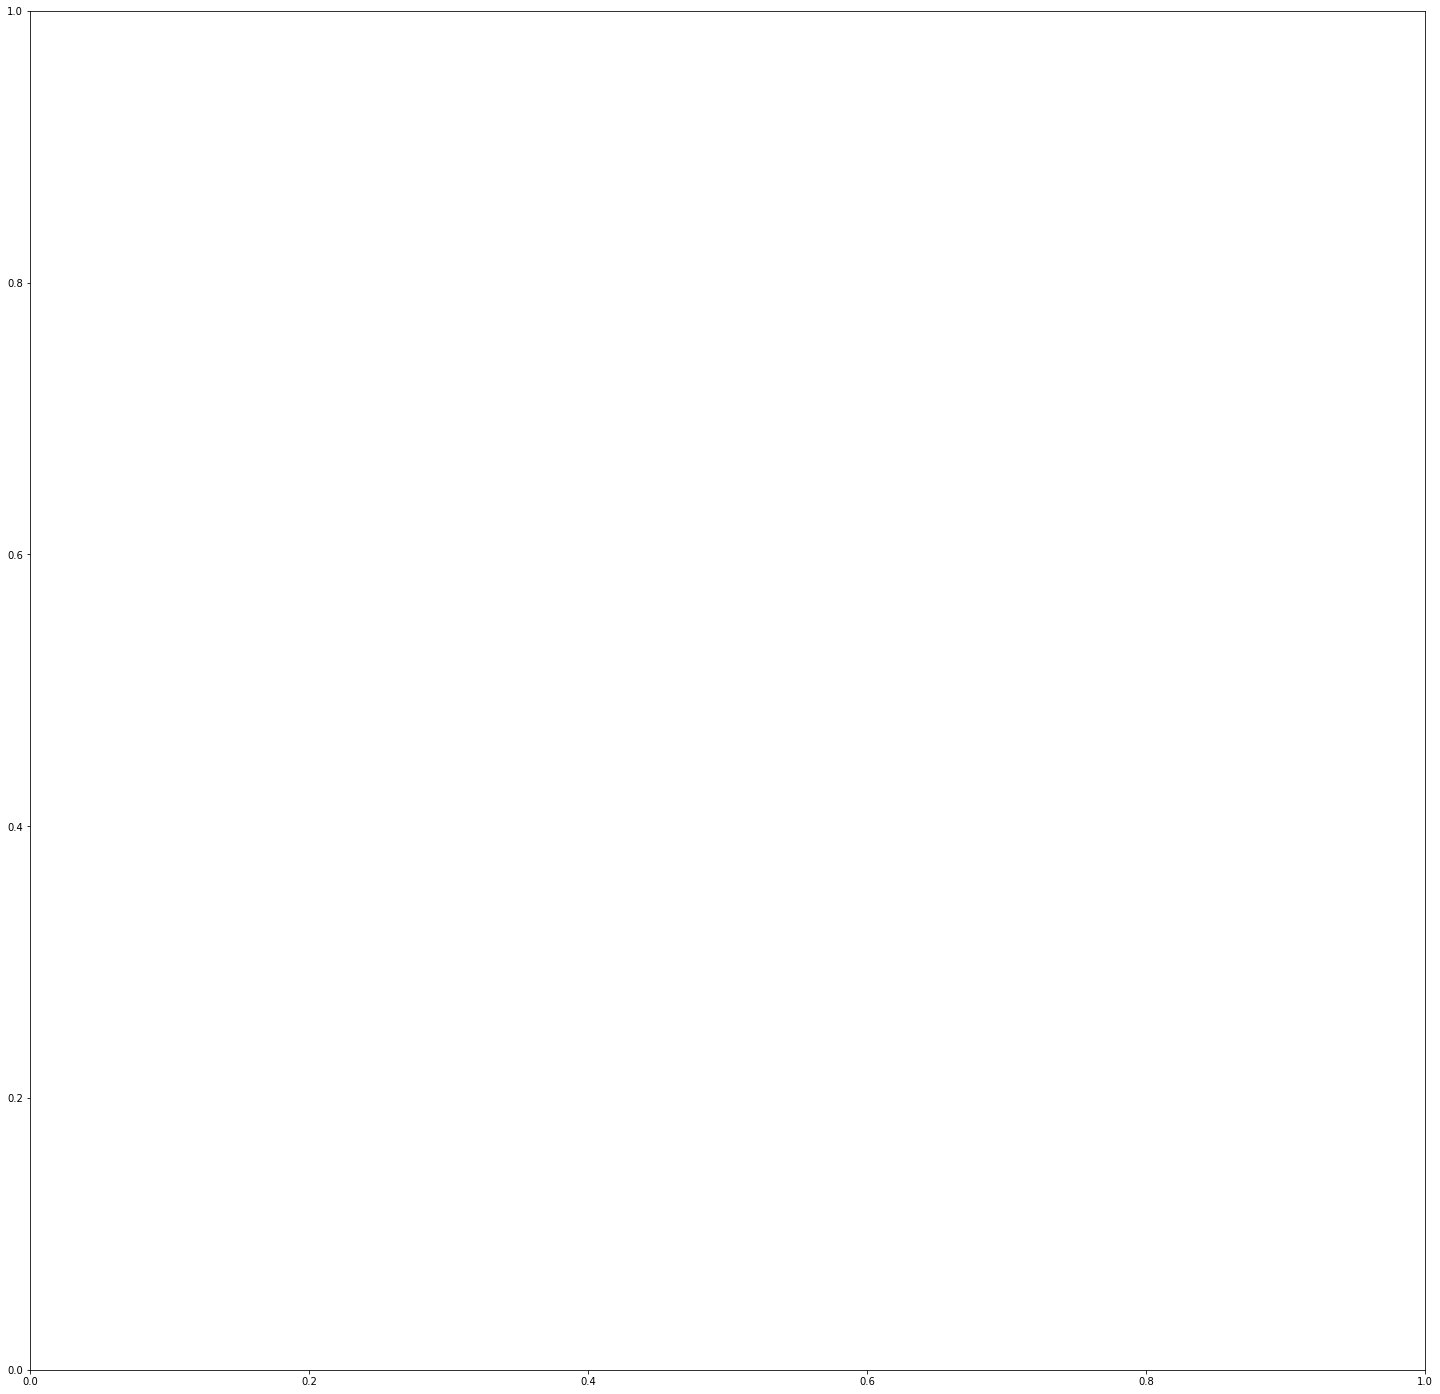

In [208]:
#1.创建一个窗口
fig,ax = plt.subplots(figsize=(25,25))
#2.创建nx对象
GA = nx.from_pandas_edgelist(city_net_top1.reset_index(),source='SSGS_city',target='ZGS_city',edge_attr='count')
#3.获取城市列表
city_lst = []
for i in city_net_top1.reset_index().SSGS_city:
    city_lst.append(i)
for i in city_net_top1.reset_index().ZGS_city:
    city_lst.append(i)
city_lst = pd.DataFrame(set(city_lst),columns=['city'])
#4.获取城市坐标
coor = pd.read_csv(r'../../file/subject/chapter3/coor_xian80.csv',names=['city','lng','lat'])
coor.city[307] = coor.city[307].replace('大湾镇','')
coor.city[309] = coor.city[309].replace('地区','市')
coor.city[7] = coor.city[7].replace('州','壮族苗族自治州')
coor.city[314] = coor.city[314].replace('苗族','苗族自治州')
data = pd.merge(city_lst,coor,how='inner')
pos = data.set_index('city').T.to_dict('list')

nx.draw(GA,pos)

In [137]:
city_net3.apply(lambda x:[x[0],x[1].strip()],axis=1)[0]

['上海市', '兰州市']

In [194]:
coor.city[314] = coor.city[314].replace('苗族','苗族自治州')

C:\Users\cc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [209]:
coor[coor.city.str.contains('济源')]

,city,lng,lat


In [203]:
city_lst

,city
0,佛山市
1,衡水市
2,太原市
3,巴音郭楞蒙古自治州
4,遂宁市
...,...
265,枣庄市
266,汉中市
267,阿克苏地区
268,柳州市


In [184]:
data.set_index('city').T.to_dict('list')['佛山市']

[1007492.6459100001, 2553871.7933900002]

,city
0,佛山市
1,衡水市
2,太原市
3,巴音郭楞蒙古自治州
4,遂宁市
...,...
265,枣庄市
266,汉中市
267,阿克苏地区
268,柳州市
